# Supervised Repertoire Classification

While solving a sequence classification can be useful in the cases where the label applies to every sequence in a sample (such as in tetramer-sorted T-cells), there are times where the label may truly only apply to a set of sequences. For example, in the case where one may sequence tumor-infiltrating lymphocytes (TIL) and  there is a label at the repertoire/sample level such as which therapy the sample received. In this case, there may be a structural signature within a set of sequences that is predictive but not every single sequence has that signature. This is a case where we want to learn what is the structural signature buried in a set of sequenes and which sequences carry this signature.

To demo this utility of a repertoire/sample level classifier, we will first upload dat from the Rudqvist dataseet. In this dataset, 20 mice with implanted tumors were treated with 4 modes of therapy (Control, 9H10, RT, or Combo). We want to know whether the TCRrepertoire from their tumors is predictive of the therapy they received.

In [1]:
import sys
sys.path.append('../../')
from DeepTCR.DeepTCR import DeepTCR_WF

# Instantiate training object
DTCR_WF = DeepTCR_WF('Tutorial')

#Load Data from directories
DTCR_WF.Get_Data(directory='../../Data/Rudqvist',Load_Prev_Data=False,aggregate_by_aa=True,
               aa_column_beta=1,count_column=2,v_beta_column=7,d_beta_column=14,j_beta_column=21)

Loading Data...
Embedding Sequences...
Data Loaded


Following loading the data, we will split our data into test/train and then train the model.

In [2]:
DTCR_WF.Get_Train_Valid_Test(test_size=0.25)
DTCR_WF.Train()

W1004 19:59:57.509597 140122212878144 deprecation_wrapper.py:119] From ../../DeepTCR/functions/Layers.py:130: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1004 19:59:57.519880 140122212878144 deprecation_wrapper.py:119] From ../../DeepTCR/functions/Layers.py:140: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1004 19:59:57.523452 140122212878144 deprecation_wrapper.py:119] From ../../DeepTCR/functions/Layers.py:141: The name tf.sparse.placeholder is deprecated. Please use tf.compat.v1.sparse.placeholder instead.

W1004 19:59:57.532828 140122212878144 deprecation_wrapper.py:119] From ../../DeepTCR/functions/Layers.py:12: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W1004 19:59:57.535385 140122212878144 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (fro

Training_Statistics: 
 Epoch: 0 Training loss: 1.39094 Validation loss: 1.38576 Testing loss: 1.37400 Training Accuracy: 0.25 Validation Accuracy: 0.25 Testing Accuracy: 0.5 Testing AUC: 0.75
Training_Statistics: 
 Epoch: 1 Training loss: 1.37786 Validation loss: 1.38356 Testing loss: 1.36689 Training Accuracy: 0.25 Validation Accuracy: 0.25 Testing Accuracy: 0.5 Testing AUC: 0.91667
Training_Statistics: 
 Epoch: 2 Training loss: 1.36791 Validation loss: 1.38254 Testing loss: 1.36054 Training Accuracy: 0.5 Validation Accuracy: 0.5 Testing Accuracy: 0.5 Testing AUC: 0.91667
Training_Statistics: 
 Epoch: 3 Training loss: 1.35890 Validation loss: 1.38136 Testing loss: 1.35342 Training Accuracy: 0.5 Validation Accuracy: 0.5 Testing Accuracy: 0.5 Testing AUC: 0.91667
Training_Statistics: 
 Epoch: 4 Training loss: 1.34975 Validation loss: 1.38031 Testing loss: 1.34597 Training Accuracy: 0.58333 Validation Accuracy: 0.25 Testing Accuracy: 0.75 Testing AUC: 0.91667
Training_Statistics: 
 Epoch

Following training, we can view the performance through plotting the ROC curves.

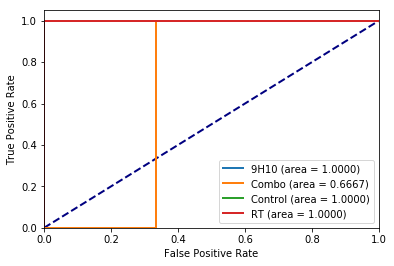

In [3]:
DTCR_WF.AUC_Curve()

You might notice that given how small this dataset is, doing one training split does not give us a good assesment for how predictive the TCR signature may be. In this case, we would want to use a K-fold cross validation to train on 19 of the samples and test on 1 and iterate until we've covered the entire cohort. When calling the K-fold cross validation command, one can provide the number of folds or if none is provided, it assumes a leave-one-out strategy. Here, we will also utilize an option for training where we apply a hinge loss to the training data where the per-sample loss is only used to penalize the model if it is above a certain threshold. This prevents over-fitting of the neural network. The idea here is that once a sample has been called correctly, there is no additional benefit to get it 'more right'. This is a particularly good training strategy when we are working with small datasets such as this one. We will also set the combine_train_valid parameter to True to combine what was originally the train and validation sets into one training set while leaving the test set for assessing performance. Otherwise, this method normally applies an early stopping criterion on the validation set. Since we have combined our train and validation sets together, we need to apply a stopping criterion on this training data. We will set the minimum loss before stopping training on the training data to 0.1. This means that when the average training loss hits 0.1, the neural network will stop training.

In [ ]:
%%capture
DTCR_WF.K_Fold_CrossVal(combine_train_valid=True, hinge_loss_t = 0.1,train_loss_min = 0.1)

We can then assess the performance once again through plotting the ROC curves.

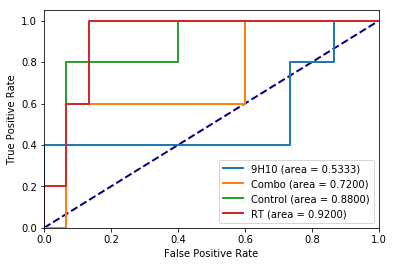

In [5]:
DTCR_WF.AUC_Curve()

We can also train our model in a Monte-Carlo fashion where we perform N number of monte-carlo simulation, randomly sampling train/test sets to train our model and assess predictive signature in our data in a more granular way. Here, we will also introduce other hyper-parameters we can modify including changing the size of the network. The size of the network parameter chooses the number of nodes for the 3 convolutional layers. Here, we will switch the sie of the network to 'small' which use 12,32,64 nodes respectively for the 3 conv layers. We will also leave out 4 samples for testing while we use 16 for training. Finally, we will also train our model with 64 concepts, a hyper-parameter of the multiple-instance learning (MIL) algorithm that we can change depending on the level of heterogeneity we expect in our data.

In [ ]:
%%capture
folds = 25
LOO = 4
epochs_min = 10
size_of_net = 'small'
num_concepts=64
hinge_loss_t = 0.1
train_loss_min=0.1

DTCR_WF.Monte_Carlo_CrossVal(folds=folds,LOO=LOO,epochs_min=epochs_min,num_concepts=num_concepts,size_of_net=size_of_net,
                             train_loss_min=train_loss_min,hinge_loss_t=hinge_loss_t,combine_train_valid=True)

Once again, we can look at the performance via a ROC curve.

In [ ]:
DTCR_WF.AUC_Curve()

Once our algorithm has been trained, we may want to see which sequences are the most strongly predicted for each label. To do this we will run the following command. The output of the command is a dictionary of dataframes within the object we can view. Additionally, these dataframes can be found in the results folder underneath the subdirectory 'Rep_Sequences'.

In [6]:
DTCR_WF.Representative_Sequences()

In [7]:
print(DTCR_WF.Rep_Seq['Control'])

      alpha              beta      v_beta      d_beta      j_beta v_alpha  \
15157  None      CASSLDRYEQYF  TCRBV14-01  TCBDD01-01  TCRBJ02-07    None   
14596  None      CASGLGEYEQYF  TCRBV13-02  TCBDD01-01  TCRBJ02-07    None   
15151  None  CASSKGDRGSNERLFF  TCRBV05-01  TCBDD01-01  TCRBJ01-04    None   
15341  None    CASSLTGRDTEVFF  TCRBV03-01  TCBDD01-01  TCRBJ01-01    None   
15230  None     CASSKAANSDYTF  TCRBV13-03  unresolved  TCRBJ01-02    None   
15426  None     CASSLGTNSDYTF  TCRBV03-01  unresolved  TCRBJ01-02    None   
15172  None    CASSLARDDERLFF  TCRBV15-01  TCBDD01-01  TCRBJ01-04    None   
14553  None     CASRGGANSDYTF  TCRBV19-01  TCBDD01-01  TCRBJ01-02    None   
14430  None     CAWSLDANSDYTF  TCRBV31-01  unresolved  TCRBJ01-02    None   
15315  None   CASSLWDRSQNTLYF  TCRBV29-01  TCBDD01-01  TCRBJ02-04    None   

      j_alpha    Class         Sample      Freq  Counts           HLA  \
15157    None  Control  CONTROL-5.tsv  0.000197       1  [N, o, n, e]   
14596 

Furthermore, we may want to know which learned motifs are associated with a given label. To do this, we can run the following command with the label we want to know the predictive motifs for.

In [8]:
DTCR_WF.Motif_Identification('Control')

Motif Identification Completed


The motifs can then be found in fasta files in the results folder underneath (label)(alpha/beta)Motifs. These fasta fiels can then be used with "https://weblogo.berkeley.edu/logo.cgi" for motif visualization.